# <center> Test shearlab tensorflow </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Importing julia
import numpy as np
import shearlab
import tfshearlab
import time

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

## Reading data

In [4]:
n = 128
m = n
gpu = 0
square = 0
name = './barbara.jpg';

In [5]:
import odl

In [6]:
space = odl.uniform_discr([-1, -1], [1, 1], [512,512])

In [7]:
phantom = odl.phantom.shepp_logan(space, True)

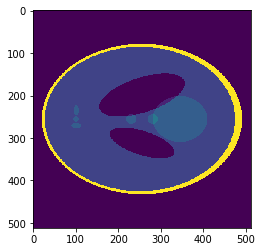

In [10]:
plt.imshow(np.array(phantom))

In [11]:
data = np.array(phantom)

## Define the shearlet system

In [12]:
sizeX = data.shape[0]
sizeY = data.shape[1]
rows = sizeX
cols = sizeY
X = data;

In [13]:
nScales = 4;
shearLevels = [float(shearlab.ceil(i/2)) for i in range(1,nScales+1)]
scalingFilter = 'Shearlab.filt_gen("scaling_shearlet")'
directionalFilter = 'Shearlab.filt_gen("directional_shearlet")'
waveletFilter = 'Shearlab.mirror(scalingFilter)'
scalingFilter2 = 'scalingFilter'
full = 0;

In [14]:
# Compute the corresponding shearlet system without gpu
tic()
shearletSystem = shearlab.getshearletsystem2D(rows,cols,nScales,shearLevels,full,directionalFilter,scalingFilter);
toc()

Elapsed time is 20.16851806640625 seconds.


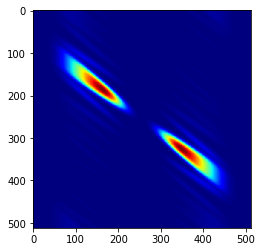

In [15]:
shearlets = shearletSystem.shearlets;
plt.imshow(shearlets.real[:,:,11], cmap='jet')

## Data, Shearlets and Dual frame weights  to tensorflow

In [17]:
import tensorflow as tf

In [18]:
shearlets = shearletSystem.shearlets
sshape = shearlets.shape
tfshearlets = tf.constant(shearlets.reshape([1,sshape[0], sshape[1], sshape[2]]), dtype=tf.complex64)

In [19]:
tfdualFrameWeights = tf.complex(tf.reduce_sum(tf.abs(tfshearlets**2),axis=3),0.)

In [21]:
Xtf = tf.constant(X.reshape([1,X.shape[0], X.shape[1]]), dtype= tf.complex64)

## Shearlet Decomposition

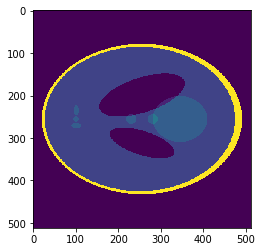

In [20]:
plt.imshow(X)

### Without tensorflow

In [26]:
t = time.time()
coeffs = shearlab.sheardec2D(X,shearletSystem)
print(time.time()-t)

1.1802735328674316


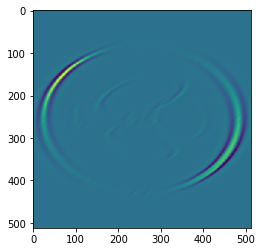

In [31]:
plt.imshow(coeffs[:,:,0])

### With tensorflow

In [29]:
t = time.time()
coeffstf = tfshearlab.tfsheardec2D(Xtf, tfshearlets)
print(time.time()-t)

0.032044410705566406


In [32]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [35]:
t = time.time()
coeffs1 = sess.run(coeffstf)
print(time.time()-t)

0.008826494216918945


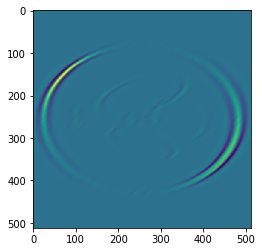

In [37]:
plt.imshow(coeffs1[0,:,:,0].real)

## Shearlet Reconstruction

### Without tensorflow

In [39]:
t = time.time()
Xrec = shearlab.shearrec2D(coeffs,shearletSystem)
print(time.time()-t)

1.0036003589630127


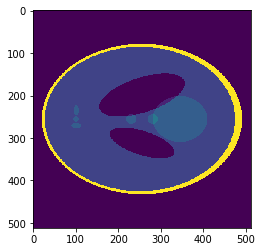

In [40]:
plt.imshow(Xrec)

### WIth tensorflow

In [45]:
t = time.time()
Xrectf = tfshearlab.tfshearrec2D(coeffstf,tfshearlets,tfdualFrameWeights )
print(time.time()-t)

0.03330826759338379


In [48]:
t = time.time()
Xrec1 = sess.run(Xrectf)
print(time.time()-t)

0.0010530948638916016


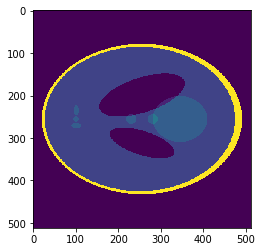

In [50]:
plt.imshow(Xrec1[0,:,:].real)